# Project: Advanced Lane Lines

In this Notebook, I am going to describe the pipeline used to detect lane Line and its curvature in a more sofisticated way than the first lane detection project.

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import copy
#import pickle

## Camera Clibration
### Finding corners

In [3]:
# prepare object points
nx = 9
ny = 6
c=1

objpoints=[]
imgpoints=[]
objp = np.zeros((nx*ny,3), np.float32)
for i in range(ny):
    for j in range(nx):
        objp[j+nx*i,:]=(j, i, 0)

# Go through images in folder collect data for calibration
for fname in glob.glob('camera_cal/*.jpg'):
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, draw corners
    print('Image: ', c, " - Retrieved corners: ", ret )
    if ret == True:
        
        objpoints.append(objp)
        imgpoints.append(corners)
    c=c+1


Image:  1  - Retrieved corners:  False
Image:  2  - Retrieved corners:  True
Image:  3  - Retrieved corners:  True
Image:  4  - Retrieved corners:  True
Image:  5  - Retrieved corners:  True
Image:  6  - Retrieved corners:  True
Image:  7  - Retrieved corners:  True
Image:  8  - Retrieved corners:  True
Image:  9  - Retrieved corners:  True
Image:  10  - Retrieved corners:  True
Image:  11  - Retrieved corners:  True
Image:  12  - Retrieved corners:  True
Image:  13  - Retrieved corners:  True
Image:  14  - Retrieved corners:  True
Image:  15  - Retrieved corners:  False
Image:  16  - Retrieved corners:  False
Image:  17  - Retrieved corners:  True
Image:  18  - Retrieved corners:  True
Image:  19  - Retrieved corners:  True
Image:  20  - Retrieved corners:  True


### Create undistortion  from found corners (example)

(1280, 720)


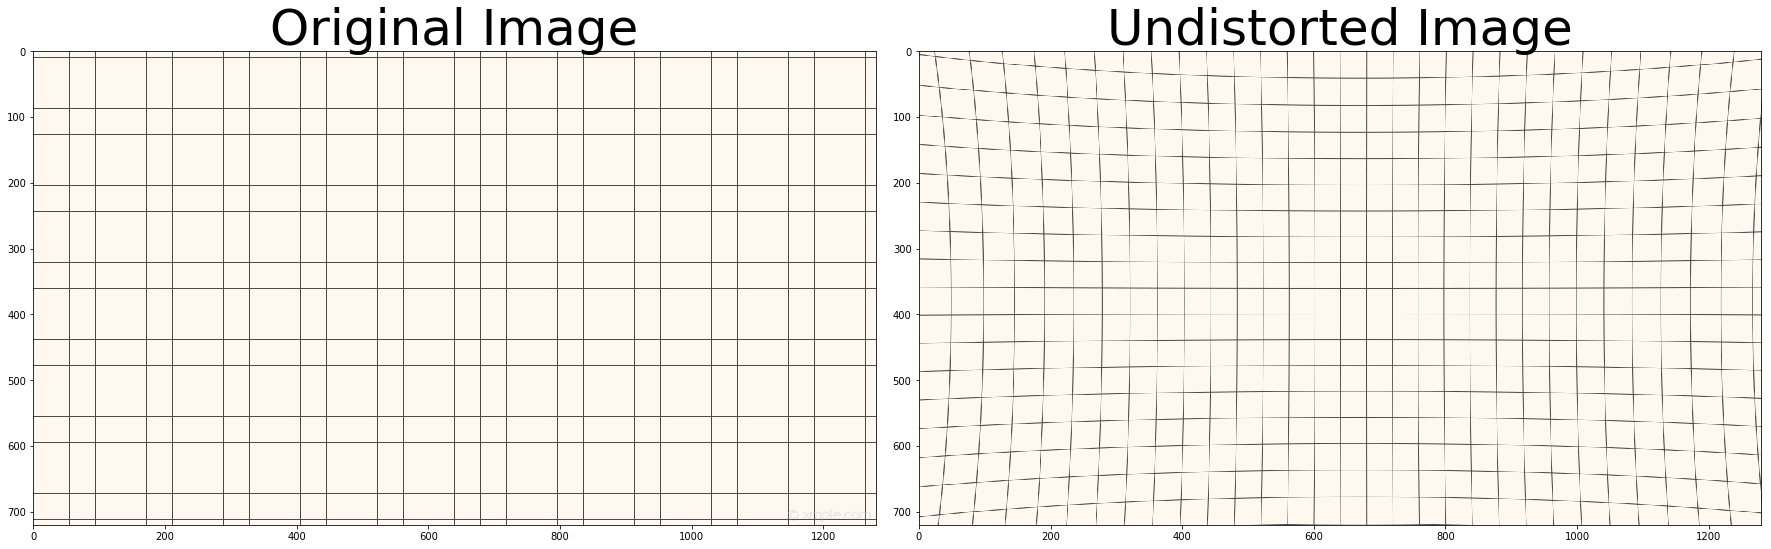

In [4]:
# Read in an image
img = cv2.imread('Resources/grid.png')


def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist=cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

print(gray.shape[::-1])

## Line Detection (using intelligent Color filtering and Sobel)
### (Including Examples)

(720, 1280, 3)
[ 133.   68.   11.] [ 150.   78.   14.]
70.0
54.0


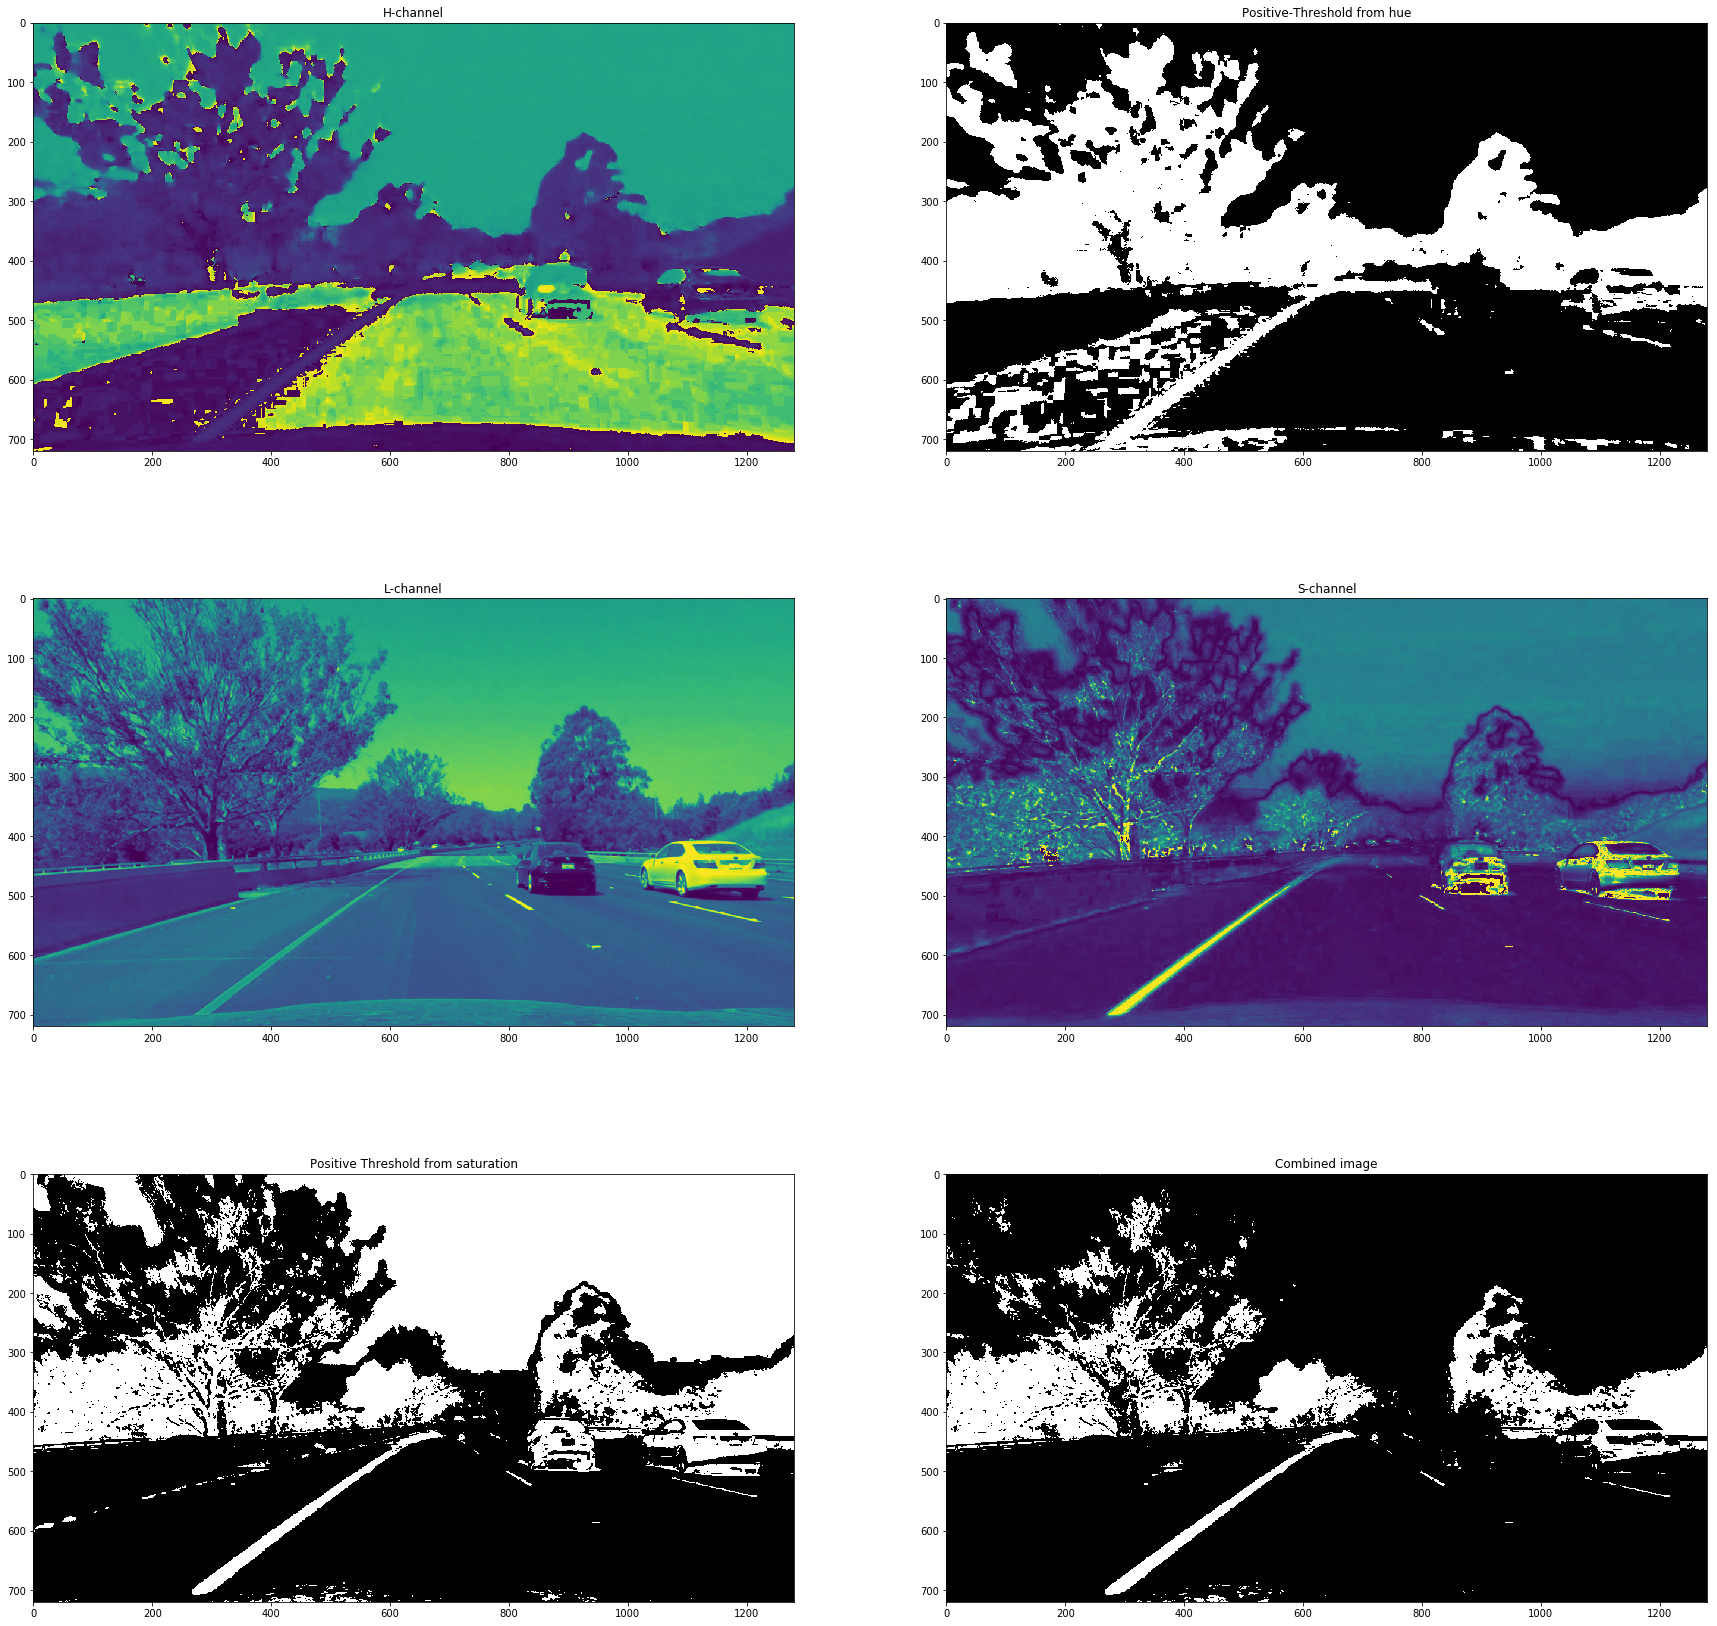

In [8]:
#img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.imread('test_images/test6.jpg')
print(img.shape)

img = cal_undistort(img, objpoints, imgpoints)

#cv2.imwrite('resources/distcorr.jpg', img)

hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

imshape=img.shape
pavement_color_low=np.percentile(hls[int(imshape[0]*0.70):int(imshape[0]*0.95),int(imshape[1]*0.45):int(imshape[1]*0.55),:],25, axis=(0,1))
pavement_color_high=np.percentile(hls[int(imshape[0]*0.70):int(imshape[0]*0.95),int(imshape[1]*0.45):int(imshape[1]*0.55),:],75, axis=(0,1))
#pavement_color=np.median(hls[int(imshape[0]/1.6):int(imshape[0]/1.1),int(imshape[1]/2.4):int(imshape[1]/1.7143),:], axis=(0,1))
print(pavement_color_low, pavement_color_high)    

h_thresh_min = 10
h_thresh_max = 60
h_binary = np.zeros_like(h_channel)
h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1

#l_thresh_min = pavement_color[1]+40
#l_thresh_max = 255
#l_binary = np.zeros_like(l_channel)
#l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

l_neg_thresh_min = 0
l_neg_thresh_max = np.minimum(pavement_color_low[1]+20,70)
print(l_neg_thresh_max)
l_neg_binary = np.zeros_like(l_channel)
l_neg_binary[(l_channel >= l_neg_thresh_min) & (l_channel <= l_neg_thresh_max)] = 1
kernel = np.ones((1,14),np.uint8)
l_neg_binary=cv2.dilate(l_neg_binary,kernel,iterations = 1)


s_thresh_min = np.maximum(pavement_color_high[2]+40,0)
print(s_thresh_min)
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1



comb_binary_c=copy.copy(s_binary)
#comb_binary_c[l_binary==1]=1
comb_binary_c[h_binary==0]=0

f, ((ax1, ax2), (ax3, ax4),(ax5, ax6)) = plt.subplots(3, 2, figsize=(30,30))
ax1.set_title('H-channel')
ax1.imshow(hls[:,:,0])
ax3.set_title('L-channel')
ax3.imshow(hls[:,:,1])
ax4.set_title('S-channel')
ax4.imshow(hls[:,:,2])

ax2.set_title('Positive-Threshold from hue')
ax2.imshow(h_binary, cmap='gray')
#ax4.set_title('Negative Threshold from lightness')
#ax4.imshow(l_neg_binary, cmap='gray')
ax5.set_title('Positive Threshold from saturation')
ax5.imshow(s_binary, cmap='gray')

ax6.set_title('Combined image')
ax6.imshow(comb_binary_c, cmap='gray')

#lnew=np.ones_like(l_channel)*122
lnew=np.copy(l_channel)
lnew[l_channel<pavement_color_high[1]]=pavement_color_high[1]

new_hls=np.dstack((h_channel,lnew,s_channel))
img_new=cv2.cvtColor(new_hls, cv2.COLOR_HLS2RGB)




done


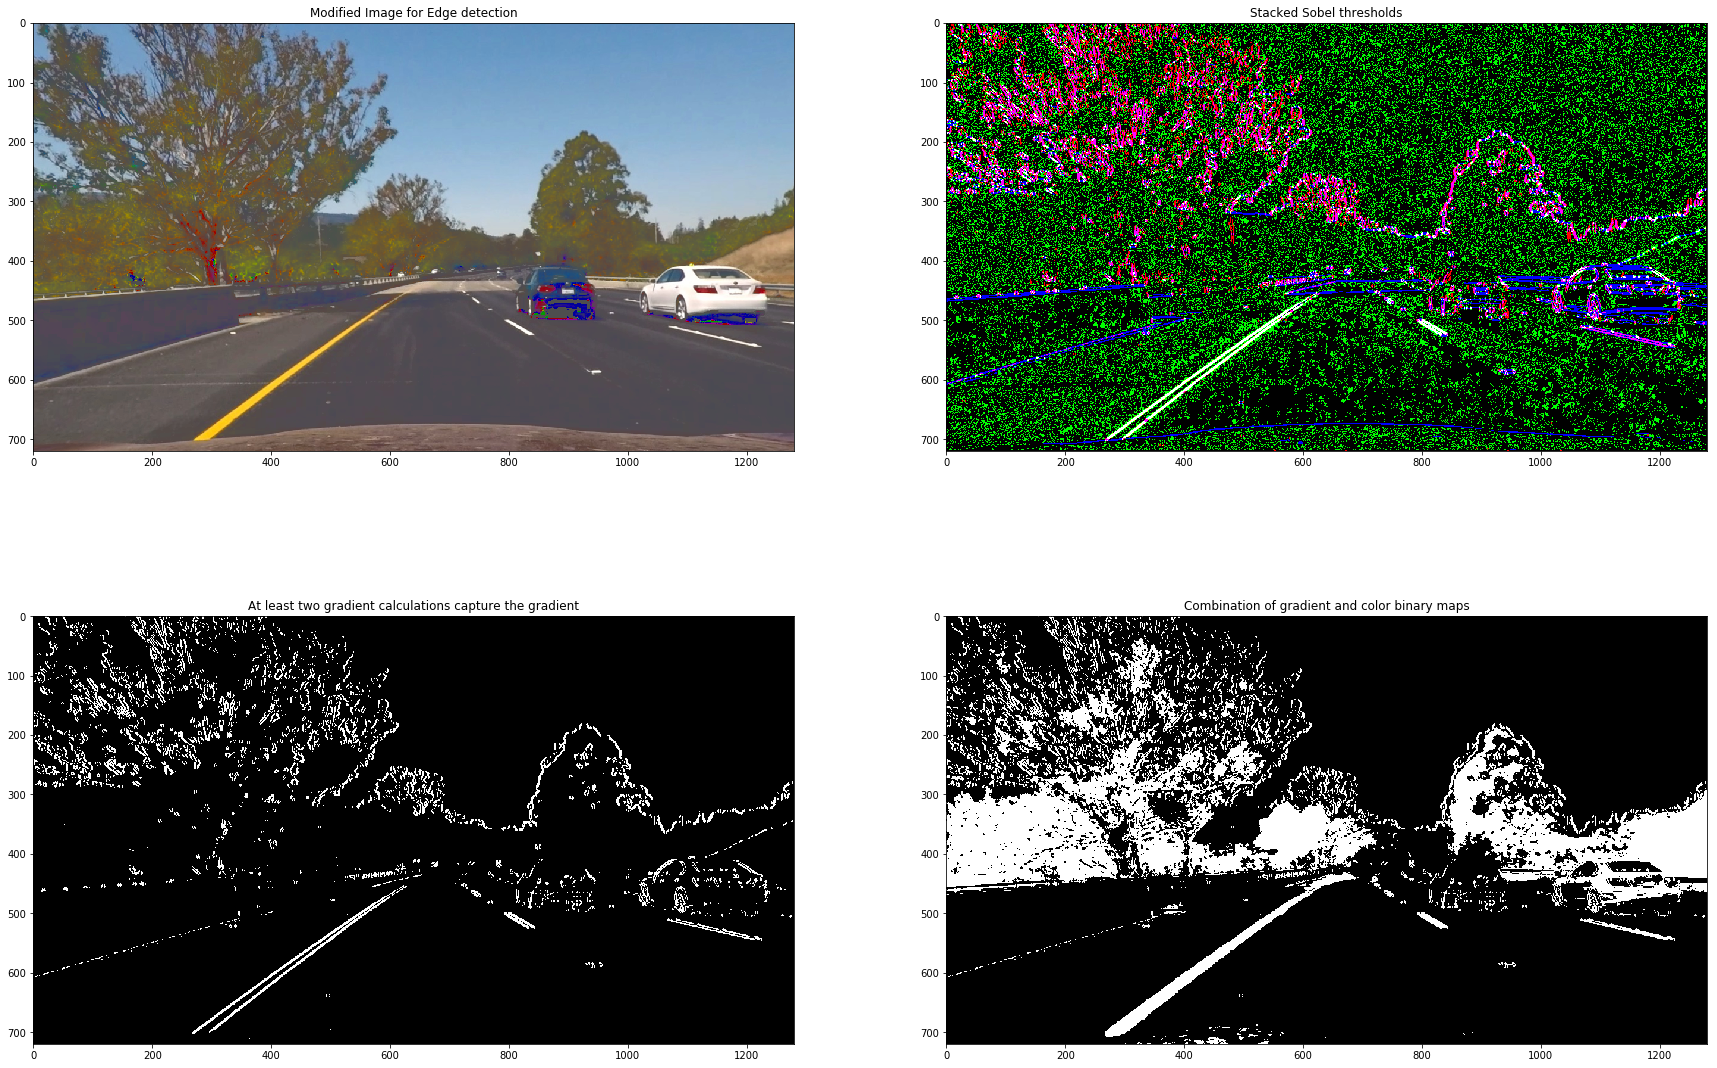

In [10]:
# in order to minimize redundancies in later calculations, I created one function for all sobel operations
def sobel_thresh(gray, sobel_kernel=3, orient='x', orient_thresh=(0, 255), dir_thresh=(0, np.pi/2), mag_thresh=(0, 255)):
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    #Gradient magnitude in one direction
    orient_binary=np.zeros_like(gray)
    if orient=='x':
        abs_sobel=np.absolute(sobelx)
    if orient=='y':
        abs_sobel=np.absolute(sobely)
        
    abs_sobel=np.uint8(255*abs_sobel/(np.max(abs_sobel)))
    flags_o=(abs_sobel >= orient_thresh[0])&(abs_sobel <=orient_thresh[1])
    orient_binary[flags_o]=1
    
    #Directional gradient filter
    dir_binary=np.zeros_like(gray)
    sobelxy=np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    flags_d=(sobelxy >= dir_thresh[0])&(sobelxy <=dir_thresh[1])
    dir_binary[flags_d]=1
    
    #Total magnitude gradient filter
    mag_binary=np.zeros_like(gray)
    sobelm=np.sqrt(sobelx*sobelx+sobely*sobely)
    sobelm=np.uint(255*sobelm/np.max(sobelm))
    flags_m=(sobelm >= mag_thresh[0])&(sobelm <=mag_thresh[1])
    mag_binary[flags_m]=1
        
    return orient_binary, dir_binary, mag_binary


#img = cv2.imread('test_images/test4.jpg')

gray=cv2.cvtColor(img_new, cv2.COLOR_RGB2GRAY)


# Choose a Sobel kernel size
ksize = 7
# Choose parameters for the gradients
# Gradient magnitude in one direction --> Later illustrated as red
orient='x'
orient_thresh=(30, 150)
# Directional gradient filter --> Later illustrated as green
dir_thresh=(0.8, 1.2)
#Total magnitude gradient filter --> Later illustrated as blue
mag_thresh=(50, 255)

# Apply each of the thresholding functions
orient_binary, dir_binary, mag_binary = sobel_thresh(gray, sobel_kernel=ksize, orient=orient, orient_thresh=orient_thresh, dir_thresh=dir_thresh, mag_thresh=mag_thresh)
print('done')
#Illustrate the gradients
color_binary = np.dstack((orient_binary, dir_binary, mag_binary)) * 255

# Combine the two binary thresholds
comb_binary_s = np.zeros_like(gray)
#combined_binary[(orient_binary == 1) | (dir_binary == 1) | (mag_binary == 1)] = 1
twos=np.ones_like(gray)*2
comb_binary_s[(orient_binary+dir_binary+mag_binary)>=twos] = 1


# Plotting thresholded images
f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(30,20))

ax1.set_title('Modified Image for Edge detection')
ax1.imshow(img_new)

ax2.set_title('Stacked Sobel thresholds')
ax2.imshow(color_binary)

ax3.set_title('At least two gradient calculations capture the gradient')
ax3.imshow(comb_binary_s, cmap='gray')


fin_binary = np.zeros_like(gray)
fin_binary[(comb_binary_s == 1)]= 1
#fin_binary[(l_neg_binary)==1]= 0

#ax3.set_title('Edgedetection with dark areas ommited')
#ax3.imshow(fin_binary, cmap='gray')


fin_binary[(comb_binary_c == 1)]= 1

ax4.set_title('Combination of gradient and color binary maps')
ax4.imshow(fin_binary, cmap='gray')



### Warp image and histogram

[[ -3.99755584e-01  -1.22359970e+00   7.67843574e+02]
 [ -3.66373598e-15  -2.67662435e+00   1.17771471e+03]
 [ -3.36102673e-18  -2.38984317e-03   1.00000000e+00]] [[  1.28906250e-01  -5.71428571e-01   5.74000000e+02]
 [  3.99680289e-15  -3.73604911e-01   4.40000000e+02]
 [  6.93889390e-18  -8.92857143e-04   1.00000000e+00]]


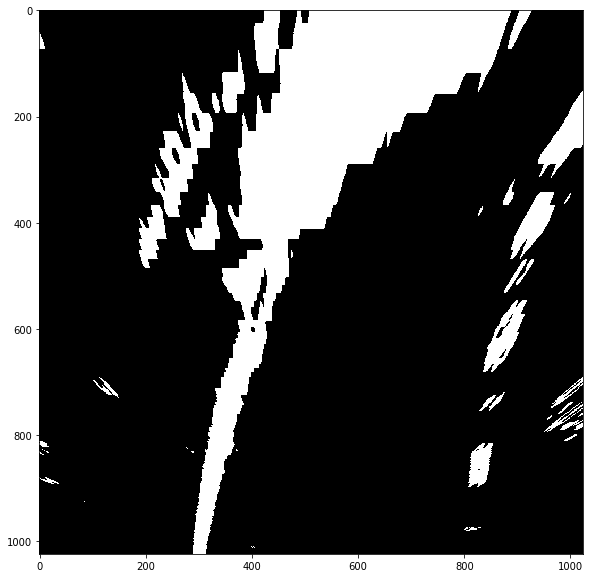

In [23]:
low_y=670
low_x=255
top_y=440
top_x=607 #545
osize=1024
o_sidemargin=osize/4
size_x=img.shape[1]
src=np.float32([[low_x,low_y],
                [top_x,top_y],
                [size_x-top_x,top_y],
                [size_x-low_x,low_y]])
dst=np.float32([[o_sidemargin,osize],
                [o_sidemargin,0],
                [osize-o_sidemargin,0],
                [osize-o_sidemargin,osize]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
binary_warped = cv2.warpPerspective(fin_binary, M, (osize,osize), flags=cv2.INTER_LINEAR)
fig99 = plt.figure(figsize = (10,10))
plt.imshow(binary_warped, cmap='gray')
print(M,Minv)


In [24]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom Half of the image


start_of_hist=int(binary_warped.shape[0]*0.5)
histogram = np.sum(binary_warped[start_of_hist:,:], axis=0)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Peak of the left and right >halves of the histogram
midpoint = np.int(histogram.shape[0]//2)
lane_mark_width=5

leftx_base = np.argmax(histogram[lane_mark_width:midpoint])+lane_mark_width 
rightx_base = np.argmax(histogram[midpoint:-lane_mark_width]) + midpoint


# Choose the number of sliding windows
nwindows = 15
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
#window_height=np.power(range(nwindows), 2)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 10
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
#Create counter, for when the lane (and thus one window boundary) leaves the projected image
out_r=0
out_l=0

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
   
    
    if (win_xleft_low<-margin/2) or (win_xleft_high>binary_warped.shape[1]+margin/2):
        out_l=out_l+2
    elif out_l>0:
        out_l=out_l-1
        
    if (win_xright_low<-margin/2) or (win_xright_high>binary_warped.shape[1]+margin/2):
        out_r=out_r+2
    elif out_r>0:
        out_r=out_r-1   
        
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    if out_l<4 and (len(good_left_inds) < window_height*margin*1.8):
        left_lane_inds.append(good_left_inds)
    if out_r<4 and (len(good_right_inds) < window_height*margin*1.8):
        right_lane_inds.append(good_right_inds)
        
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.median(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.median(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(osize-lefty, leftx, 2)
right_fit = np.polyfit(osize-righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(osize-1,0, osize)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx =right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(1024, 0)

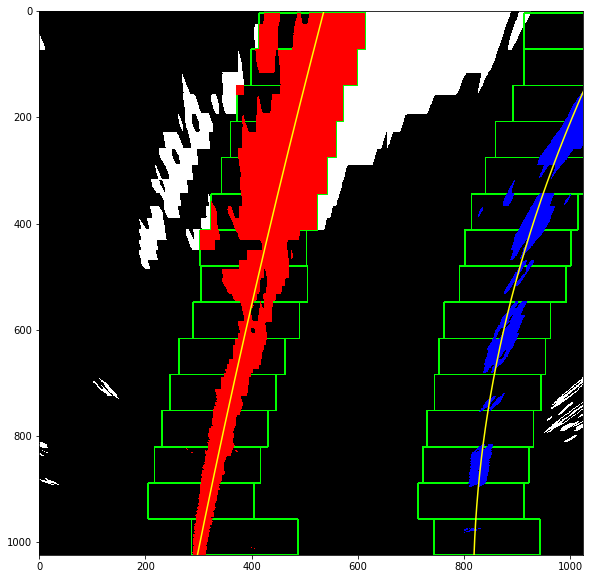

In [17]:


out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
fig98 = plt.figure(figsize = (10,10))
plt.imshow(out_img)
plt.plot(left_fitx, osize-ploty, color='yellow')
plt.plot(right_fitx, osize-ploty, color='yellow')
plt.xlim(0, osize)
plt.ylim(osize, 0)
#plt.savefig('foo.png', bbox_inches='tight',dpi=300)

In [18]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = 1024-np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(osize-lefty, leftx, 2)
right_fit = np.polyfit(osize-righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(osize-1,0, osize)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


(1024, 0)

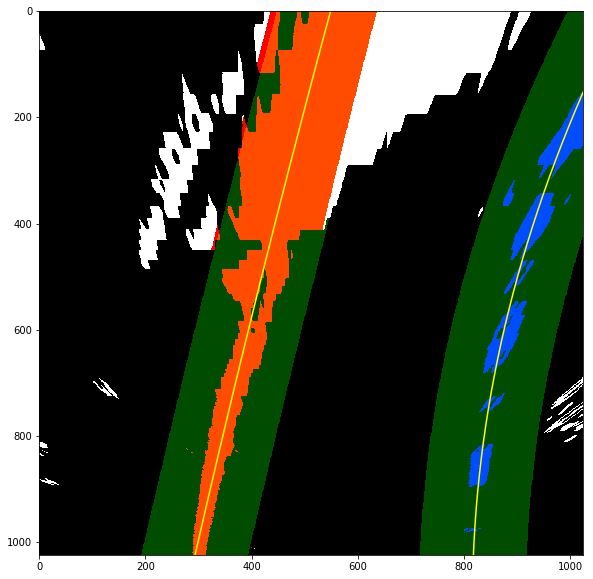

In [20]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[1024-nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[1024-nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
fig97 = plt.figure(figsize = (10,10))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, osize)
plt.ylim(osize, 0)

In [25]:
def find_curvature_and_offset(ploty, left_fitx, right_fitx):
    y_eval = np.max(ploty)
    ym_per_pix = 30/y_eval # meters per pixel in y dimension
    xm_per_pix = 3.7/y_eval*0.65 # meters per pixel in x dimension
   

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate offset
    start_l=left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    start_r=right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    offset=(start_l+ start_r-y_eval)/2.0*xm_per_pix
    return left_curverad, right_curverad, offset
    

left_curverad, right_curverad, offset=find_curvature_and_offset(ploty, left_fitx, right_fitx)
print(offset, 'm')
print(left_curverad, 'm', right_curverad, 'm')


0.715169276913 m
6443.81323543 m 793.132388028 m


left


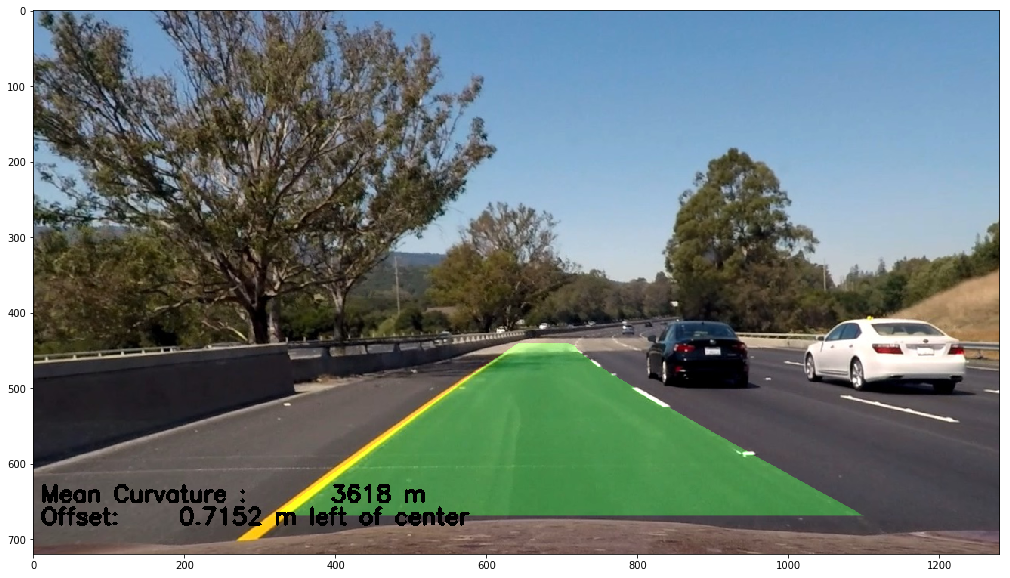

In [26]:
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, osize-ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, osize-ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = cv2.addWeighted(img_rgb, 1, newwarp, 0.3, 0)
mean_curve=(left_curverad+right_curverad)//2
if offset>0:
    lor='left'
else:
    lor='right'
print(lor)
#'Mean Curvature of Lane : %10.0f m \nOffset (left is pos.): %10.4f m' %(mean_curve, offset)
font=cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result,'Mean Curvature : %10.0f m' %mean_curve, (10,650), font, 1, (0,0,0),3)
cv2.putText(result,'Offset: %10.4f m %s of center' %(np.abs(offset), lor), (10,680), font, 1, (0,0,0),3)
fig98 = plt.figure(figsize = (20,10))
plt.imshow(result)
plt.savefig('foo2.jpg', bbox_inches='tight',dpi=300)

In [14]:
print(right_fitx[-1])

1095.80311676


---

## Main Pipeline
### Load Images